## Re-entrant Corner Problem

Here we will consider the classic _re-entrant corner_ problem,
\begin{align*}
  -\Delta u &= f, && \text{in } \Omega, \\
          u &= g, && \text{on } \partial\Omega,
\end{align*}
where the domain is given using polar coordinates,
\begin{gather*}
  \Omega = \{ (r,\varphi)\colon r\in(0,1), \varphi\in(0,\Phi) \}~.
\end{gather*}
For the boundary condition $g$, we set it to the trace of the function $u$, given by
\begin{gather*}
  u(r,\varphi) = r^{\frac{\pi}{\Phi}} \sin\big(\frac{\pi}{\Phi} \varphi \big)
\end{gather*}

We first define the domain and set up the grid and space.

In [1]:
try:
    %matplotlib inline # can also use notebook or nbagg
except:
    pass
import math
import numpy
import dune.create as create
import matplotlib.pyplot as pyplot
from dune.fem.view import adaptiveLeafGridView as gridView
from dune.fem.plotting import plotPointData as plot
import dune.grid as grid
import dune.fem as fem

# set the angle for the corner (0<angle<=360)
cornerAngle = 320.

# use a second order space
order = 2

# define the grid for this domain (vertices are the origin and 4 
# equally spaced points on the unit sphere starting with (1,0) and 
# ending at (cos(cornerAngle), sin(cornerAngle))
vertices = numpy.zeros((8, 2))
vertices[0] = [0, 0]
for i in range(0, 7):
    vertices[i+1] = [math.cos(cornerAngle/6*math.pi/180*i), 
                     math.sin(cornerAngle/6*math.pi/180*i)]
triangles = numpy.array([[2,1,0], [0,3,2], [4,3,0], 
                         [0,5,4], [6,5,0], [0,7,6]])
domain = {"vertices": vertices, "simplices": triangles}
view = gridView( "ALUConform", domain, dimgrid=2)
view.hierarchicalGrid.globalRefine(2)
space  = lagrange(view, dimrange=1, order=order)

2019-01-17 10:50:25,223 - dune.common - INFO - MPI initialized successfully
2019-01-17 10:50:25,242 - dune.common.module - INFO - Using existing dune-py module in /home/dedner/Envs/dune3/.cache/dune-py
2019-01-17 10:50:25,243 - dune.generator.builder - INFO - using pre configured dune-py module
2019-01-17 10:50:25,389 - dune.create - INFO - Importing create registries from [ dune.femnv dune.functions dune.grid dune.fem dune.alugrid dune.femdg dune.vem dune.polygongrid ]
2019-01-17 10:50:25,569 - dune.generator.builder - INFO - Loading HierarchicalGrid
2019-01-17 10:50:26,214 - dune.generator.builder - INFO - Loading ReferenceElements
2019-01-17 10:50:26,795 - dune.generator.builder - INFO - Loading ReferenceElements
2019-01-17 10:50:27,376 - dune.generator.builder - INFO - Loading ReferenceElements
2019-01-17 10:50:27,957 - dune.generator.builder - INFO - Loading GridView
2019-01-17 10:50:28,575 - dune.generator.builder - INFO - Loading Space


Next we define the model together with the exact solution.

In [2]:
from ufl import *
from dune.ufl import DirichletBC
u = TrialFunction(space)
v = TestFunction(space)
x = SpatialCoordinate(space.cell())

# exact solution for this angle
Phi = cornerAngle / 180 * pi
phi = atan_2(x[1], x[0]) + conditional(x[1] < 0, 2*pi, 0)
exact = as_vector([inner(x, x)**(pi/2/Phi) * sin(pi/Phi * phi)])
a = inner(grad(u), grad(v)) * dx

# set up the scheme
laplace = create.scheme("galerkin", [a==0, 
                        DirichletBC(space, exact, 1)])
uh = space.interpolate(lambda x: [0], name="solution")

2019-01-17 10:50:29,218 - dune.generator.builder - INFO - Loading integrands
2019-01-17 10:50:29,831 - dune.generator.builder - INFO - Loading Scheme
2019-01-17 10:50:30,456 - dune.generator.builder - INFO - Loading gridfunctions


Theory tells us that
\begin{align*}
  \int_\Omega |\nabla(u-u_h)|^2 \leq \sum_K \eta_K,
\end{align*}
where on each element $K$ of the grid the local estimator is given by
\begin{align*}
  \eta_K = h_K^2 \int_K |\triangle u_h|^2 +
    \frac{1}{2}\sum_{S\subset \partial K} h_S \int_S [\nabla u_h]^2.
\end{align*}
Here $[\cdot]$ is the jump in normal direction over the edges of the grid.

We compute the elementwise indicator by defining a bilinear form
\begin{align*}
  \eta(u,v) = \int_\Omega h^2 |\triangle u_h|^2 v +
    \int_{I_h} h_S [\nabla u_h]^2 \{v\},
\end{align*}
where $\{\cdot\}$ is the average over the cell edges and $[\cdot]$
the jump. With $h$ and $h_S$ we denote local grid spacings and with
$I_h$ the set of all facets in the grid.
This bilinear form can be easily written in UFL and by using it to
define a discrete operator $L$ from the second order Lagrange space into a space containing piecewise constant functions
we have $L[u_h]|_{K} = \eta_K$.

In [4]:
# energy error
h1error = inner(grad(uh - exact), grad(uh - exact))

# residual estimator
fvspace = create.space("finitevolume", view, dimrange=1)
estimate = fvspace.interpolate([0], name="estimate")

hT = MaxCellEdgeLength(space.cell())
he = MaxFacetEdgeLength(space.cell())('+')
n = FacetNormal(space.cell())
estimator_ufl = hT**2 * (div(grad(u[0])))**2 * v[0] * dx + he * \
                inner(jump(grad(u[0])), n('+'))**2 * avg(v[0]) * dS
estimator = create.operator("galerkin", estimator_ufl, space, fvspace)
# marking strategy (equidistribution)
tolerance = 0.1

2019-01-17 10:57:33,728 - dune.generator.builder - INFO - Loading Space
2019-01-17 10:57:34,350 - dune.generator.builder - INFO - Loading Operator (updated)


Let us solve over a timeloop and plot the solutions side by side.

2019-01-17 10:58:21,792 - dune.generator.builder - INFO - Loading localfunctionufl
2019-01-17 10:58:22,445 - dune.generator.builder - INFO - Loading GridAdaptation


0 : size= 24 estimate= 1.2432410911596732 error= 0.16712344009166372
(14, 0)
1 : size= 42 estimate= 0.978048130246281 error= 0.14720112527998955
(12, 0)
2 : size= 60 estimate= 0.5688675689128694 error= 0.11275722967161701
(12, 0)


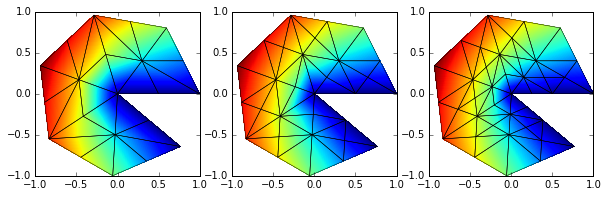

3 : size= 78 estimate= 0.4535122531152006 error= 0.09976842792407031
(12, 0)
4 : size= 96 estimate= 0.2693942671508857 error= 0.07693184059957692
(12, 0)
5 : size= 114 estimate= 0.2172009275629982 error= 0.06830968010788681
(12, 0)


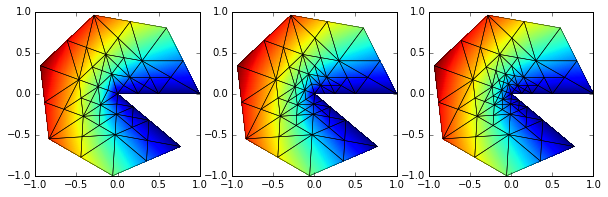

6 : size= 132 estimate= 0.13322751899605784 error= 0.05316117525018501
(10, 0)
7 : size= 146 estimate= 0.11095444323335994 error= 0.047637860971865245
(12, 0)
8 : size= 168 estimate= 0.0709339821311813 error= 0.037539566682446235


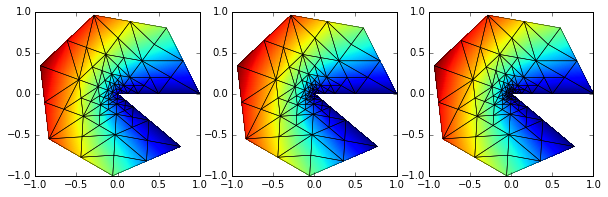

In [5]:
# adaptive loop (solve, mark, estimate)
fig = pyplot.figure(figsize=(10,10))
count = 0
while count < 20:
    laplace.solve(target=uh)
    if count%3 == 0:
        pyplot.show()
        pyplot.close('all')
        fig = pyplot.figure(figsize=(10,10))
    plot(uh, figure=(fig, 131+count%3), colorbar=False)
    # compute the actual error and the estimator
    error = math.sqrt(fem.function.integrate(view, h1error, 5)[0])
    estimator(uh, estimate)
    eta = sum(estimate.dofVector)
    print(count, ": size=", view.size(0), "estimate=", eta, 
          "error=", error)
    if eta < tolerance:
        break
    if tolerance == 0.:
        view.hierarchicalGrid.globalRefine(2)
        uh.interpolate([0])  # initial guess needed
    else:
        marked = fem.mark(estimate,tolerance/view.size(0))
        fem.adapt([uh])
        fem.loadBalance([uh])
    laplace.solve( target=uh )
    count += 1
pyplot.show()
pyplot.close('all')

Let's have a look at the center of the domain:

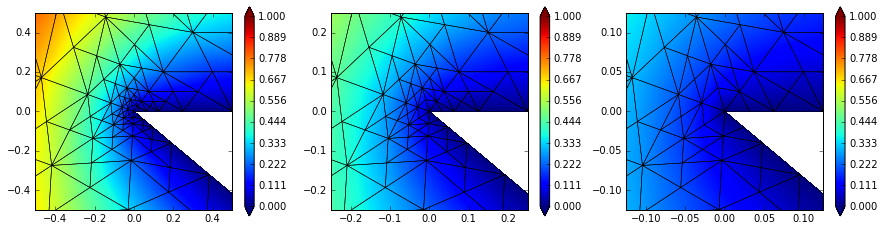

In [6]:
fig = pyplot.figure(figsize=(15,15))
plot(uh, figure=(fig, 131), xlim=(-0.5, 0.5), 
     ylim=(-0.5, 0.5), colorbar={"shrink": 0.25})
plot(uh, figure=(fig, 132), xlim=(-0.25, 0.25),
     ylim=(-0.25, 0.25),colorbar={"shrink": 0.25})
plot(uh, figure=(fig, 133), xlim=(-0.125, 0.125), 
     ylim=(-0.125, 0.125),colorbar={"shrink": 0.25})
pyplot.show()
pyplot.close('all')

Finally, let us have a look at the grid levels.

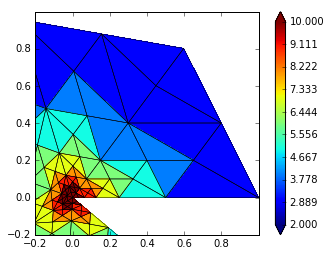

In [7]:
from dune.fem.function import levelFunction
plot(levelFunction(view), xlim=(-0.2,1), ylim=(-0.2,1))